# Titanic Feature Engineering and Model Creation with ChatGPT

The goal of this notebook is do some feature engineering on the dataset of the [Titanic Kaggle Competition](https://www.kaggle.com/competitions/titanic) and to later create a Fast.AI-`learner` to submit the result to Kaggle - supported by ChatGPT. 

This notebook [builds upon my previous notebook](https://github.com/chrwittm/FastAI2022/blob/main/lesson05/titanic-eda-and-1r-v1.2.ipynb), and I continue to use ChatGPT as a translator from English to Python. (Prompts will be indicated by the chat emoji 💬)

## Key learnings

While [EDA worked really well with ChatGPT](https://github.com/chrwittm/FastAI2022/blob/main/lesson05/titanic-eda-and-1r-v1.2.ipynb), feature engineering was more of a challenge. Here is a short summary:

* Initially, I tried to prompted ChatGPT to do the complete feature engineering task in one prompt. This apparently still left quite some room for interpretation, and, while generally going in the right direction, ChatGPT sometimes did interesting moves like inventing new passengers (as augmented data), or it went straight ahead to create a model (even though I did not ask for that).
* To solve this problem, I took smaller steps: First, I asked ChatGPT for ideas on which features could be extracted. Afterwards I prompted it to write functions to extract the features.
* Combining these functions, writing a wrapper so that the training set and the test set would be processed the same way, also yielded "interesting" results. At first glance, the code look good, but ChatGPT had forgotten how the interfaces looked for some functions, so the code did not work, but it was a template for manual re-work. It seems that ChatGPT seems to struggle with tasks when you prompt it go reuse a lot of code from previous cells in the same discussion.
* When prompted to create a Fast.AI-`lerner`, the results superficially looked good, sometimes it trained, but I did not succeed to prompt it to use the model on the test data. Either ChatGPT did not read enough about Fast.AI, or I need to improve my prompting skills. Therefore, I wrote that piece myself.

## Notebook Preparation

In this section, let's do the imports and load the data. In addition, I have collected some formatting options from other notebooks which can be used if needed.

In [47]:
from fastai.imports import * #https://github.com/fastai/fastai/blob/master/fastai/imports.py
np.set_printoptions(linewidth=130)      #<- adjust this to your liking
#pd.options.display.max_colwidth = 200  #<- adjust this to your liking
#pd.options.display.max_rows = 500      #<- adjust this to your liking
#plt.rc('figure', dpi=90)               #<- adjust this to your liking

In [48]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)


In [49]:
df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')

In [50]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Creating a list of columns: 

In [51]:
columns = df.columns.tolist()
print(df.columns.tolist())
print(len(columns))

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
12


## Cleaning the Dataset

Before we get going to engineer the features, let's clean the dataset. But which ones are the problematic columns?

> 💬: Write a function to determine which columns contain missing values

In [52]:
def get_columns_with_missing_values(df):
    """
    Returns a list of column names that contain missing values
    """
    columns_with_missing_values = df.columns[df.isnull().any()].tolist()
    return columns_with_missing_values

When calling the functions we get a good result:

In [53]:
print(get_columns_with_missing_values(df))
print(get_columns_with_missing_values(tst_df))

['Age', 'Cabin', 'Embarked']
['Age', 'Fare', 'Cabin']


Nice, we now know which columns to handle:

> 💬: Write a function to deal with missing values in the dataset in the columns 'Age', 'Cabin', 'Embarked', 'Fare',  and call this function on the dataframe df.

As a result, ChatGPT tried to implement a random forest for determining the age, but that code did not work, so I took the minimalistic route, but kept the code as comments for preserving the idea:

In [54]:
from sklearn.ensemble import RandomForestRegressor

def handle_missing_values(df):
    
    #"""
    #Imputes missing values in the 'Age', 'Embarked', 'Fare', and 'Cabin' columns using machine learning.
    #"""
    ## Impute 'Age' column using a random forest regressor
    #age_df = df[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch']]
    #age_df_known = age_df[age_df['Age'].notnull()]
    #age_df_unknown = age_df[age_df['Age'].isnull()]
    #X_train = age_df_known.drop('Age', axis=1)
    #y_train = age_df_known['Age']
    #rf = RandomForestRegressor(n_estimators=200, random_state=42)
    #rf.fit(X_train, y_train)
    #predicted_ages = rf.predict(age_df_unknown.drop('Age', axis=1))
    #df.loc[df['Age'].isnull(), 'Age'] = predicted_ages
    
    # Impute 'Embarked' column with median
    df['Age'].fillna(df['Age'].median(), inplace=True)
    
    # Impute 'Embarked' column with mode
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    # Impute 'Fare' column with median
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # Impute 'Cabin' column with a new category 'U' for 'Unknown'
    df['Cabin'].fillna('U', inplace=True)
    
    return df

# Call the function on the dataframe 'df'
df = handle_missing_values(df)
print(get_columns_with_missing_values(df))

[]


## Feature Engineering

Before writing code, I asked ChatGPT about suggestions on how to start the task:

> 💬: We are going to work on the Titanic tabular kaggle competition. The task is to classify whether passengers survived or not (binary classification). There are 10 available features in the dataset, here's a list: 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'.
> Which additional features do you propose to engineer to enhance the dataset? Explain the logic why you would create which additional features.

![](ChatGPT-answer03.png)

ChatGPT again demonstrated that it know the dataset, suggested some good features and it also explained why they were good features.

I also asked for more features, but let's keep this short and sweet.

Now let's create some additional features.

> 💬: Create python functions, one per feature, to create the following features: Title, Family Size, Age Group, Fare Group, Ticket Frequency, Deck.

> Note, below, I added some tests to each function, but commented them later for better readability.

In [61]:
import re

def get_title(name):
    """
    Extracts the title from the name column
    """
    title = re.search(' ([A-Za-z]+)\.', name)
    if title:
        return title.group(1)
    return ""
    
# Applying the function to the dataset
df['Title'] = df['Name'].apply(get_title)
#df[['Name', 'Title']].head()

In [62]:
def get_family_size(df):
    """
    Combines the SibSp and Parch columns to obtain the total size of the passenger's family
    """
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    return df

# Applying the function to the dataset
#df = get_family_size(df)
#df[['SibSp', 'Parch', 'FamilySize']].head()

In [63]:
def get_age_group(age):
    """
    Bins the age column into different age groups
    """
    if age < 18:
        return 'Child'
    elif age < 65:
        return 'Adult'
    else:
        return 'Senior'

# Applying the function to the dataset    
#df['AgeGroup'] = df['Age'].apply(get_age_group)
#df[['AgeGroup', 'Age']].head()

In [64]:
def get_fare_group(fare):
    """
    Bins the fare column into different fare groups
    """
    if fare < 10:
        return 'Low'
    elif fare < 30:
        return 'Medium'
    else:
        return 'High'

# Applying the function to the dataset
#df['FareGroup'] = df['Fare'].apply(get_fare_group)

In [65]:
def split_cabin(cabin):
    """
    Splits the given cabin string into 'Deck' and 'CabinNumber' components.
    Returns a tuple containing 'Deck' and 'CabinNumber' values.
    """
    if pd.isna(cabin):
        return (np.nan, np.nan)
    else:
        deck = cabin[0]
        cabin_number = cabin[1:]
        return (deck, cabin_number)

#df[['Deck', 'CabinNumber']] = df['Cabin'].apply(split_cabin).apply(pd.Series)
#df[['Cabin', 'Deck', 'CabinNumber']].head(20)

## Reworking some of the functions

While the resulting functions worked well, human insight is needed to improve some of the features. As a reminder, ChatGPT does not see the result of EDA **LINK** and has no way of verifying, if it used, for example, well-suited bins.

Let's check the Title column:

In [66]:
df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

There are too many values with very low occurences:

> 💬: Rewrite the get_title function so that anything else but Mr, Miss, Mrs and Master is put into an 'Other' category, also make sure that no initial value is returned.

In [67]:
import re

def get_title(name):
    """
    Extracts the title from the name column
    """
    title = re.search(' ([A-Za-z]+)\.', name)
    if title:
        title = title.group(1)
        if title not in ['Mr', 'Miss', 'Mrs', 'Master']:
            title = 'Other'
    else:
        title = None
    return title

# Applying the function to the dataset
df['Title'] = df['Name'].apply(get_title)
#df[['Name', 'Title']].head()

In [68]:
df['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: Title, dtype: int64

From EDA we know that just differentiating between Child, Adult, and Senior is not enough:

<img src="survival-rate-by-age-group.png" alt="drawing" width="800"/>

Therefore:

> 💬: Rewrite the get_age_group function to generate the following bins [0, 6, 12, 18, 30, 60, 100], name the bins appropriately

In [69]:
def get_age_group(age):
    """
    Returns the age group based on the given age.
    """
    if pd.isnull(age):
        return 'Unknown'
    elif age <= 6:
        return 'Infant'
    elif age <= 12:
        return 'Child'
    elif age <= 18:
        return 'Teenager'
    elif age <= 30:
        return 'Young Adult'
    elif age <= 60:
        return 'Adult'
    else:
        return 'Senior'
    
#df['AgeGroup'] = df['Age'].apply(get_age_group)
#df[['AgeGroup', 'Age']].head()

The Fare Groups were not really meaningful. Looking back at EDA, some other groups would probably yield better results:

<img src="survival-rate-by-fare-group.png" alt="drawing" width="800"/>

> 💬:
Rewrite the get_fare_group function so that the following bins are created: [0, 7, 10, 20, 50, 100, 600], name the bins appropriately

In [70]:
def get_fare_group(fare):
    """
    Categorizes the given fare into groups based on the following bins: [0, 7, 10, 20, 50, 100, 600]
    """
    if fare <= 7:
        return 'Very Low'
    elif fare <= 10:
        return 'Low'
    elif fare <= 20:
        return 'Mid'
    elif fare <= 50:
        return 'High'
    elif fare <= 100:
        return 'Very High'
    else:
        return 'Extreme'

# Applying the function to the dataset
#df['FareGroup'] = df['Fare'].apply(get_fare_group)
#df[['FareGroup', 'Fare']].head()

## Running the Feature Engineering

Now we are ready to use the functions for feature engineering:

> 💬: Create function which reuses all the functions that we created to create the additional features for a dataframe.

The result was not bad, just that it did not work. ChatGPT forgot how some of the interfaces of the functions were implemented. Additionally, it wanted to call a function that ChatGPT had suggested (TicketFrequency), but which was never implemented... With a bit of adjustment:

In [71]:
def create_additional_features(df):
    # Get passenger titles
    df['Title'] = df['Name'].apply(get_title)

    # Get family size
    df = get_family_size(df)

    # Get age groups
    df['AgeGroup'] = df['Age'].apply(get_age_group)

    # Get fare groups
    df['FareGroup'] = df['Fare'].apply(get_fare_group)

    # Split cabin into deck and cabin number
    df[['Deck', 'CabinNumber']] = df['Cabin'].apply(split_cabin).apply(pd.Series)

    # Drop original columns
    #df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True) # Not dropping so I can run this several times

    return df

df = handle_missing_values(df)
df = create_additional_features(df)

In [72]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize',
       'AgeGroup', 'FareGroup', 'Deck', 'CabinNumber'],
      dtype='object')

In [73]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,AgeGroup,FareGroup,Deck,CabinNumber
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,2,Young Adult,Low,U,
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,Adult,Very High,C,85
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,1,Young Adult,Low,U,
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,Adult,Very High,C,123
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,1,Adult,Low,U,


## Creating a Model

While ChatChatGPT could create a model, the overall results were not overly great. Particularly, the result did not beat the baseline of a binary classification by gender.

To be honest, I also need to play with the data quite a bit to consistently beat the baseline. In the final version (adjusted from ChatGPT's code), I got rid of many features, but used the engineered ones.

I also switched the `y_block` to a `CategoryBlock()` - inspired by the notebook "[Why you should use a Framework](https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework)" and also by [lesson 6 of the 2020 edition](https://youtu.be/cX30jxMNBUw?t=2884).

With this limited amount of data, the Fast.AI standard model performed the best. Increasing the model size actually worsened the result.

For the learning rate I decided to use the `lr_max`-parameter which adjusts the learning rate as explained in [lesson 6 of the 2020 edition](https://youtu.be/cX30jxMNBUw?t=1318).

In [46]:
from fastai.tabular.all import *

cat_vars = ['Sex', 'Title', 'Deck', 'AgeGroup', 'FareGroup', 'Pclass'] #'CabinNumber', 'Embarked'
cont_vars = ['FamilySize'] # 'Age', 'SibSp', 'Parch', 'Fare', 'FarePerPerson', 'TravellingAlone'

# Define the dependent variable
dep_var = 'Survived'

# Define the procs
procs = [Categorify, FillMissing, Normalize]

# Split the dataset into training and validation sets
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

# Create the tabular pandas object
to = TabularPandas(df, procs=procs, cat_names=cat_vars, cont_names=cont_vars, y_names=dep_var, splits=splits, y_block = CategoryBlock())

# Create the dataloaders
dls = to.dataloaders(bs=64)

# Create the learner
learn = tabular_learner(dls, metrics=accuracy)#, layers=[500,200])#, loss_func=CrossEntropyLossFlat(), lr=0.001) #increasing the model size does not improve the result

# Train the model
learn.fit_one_cycle(10, lr_max=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.553512,0.616140,0.623595,00:00
1,0.533270,0.484382,0.780899,00:00
2,0.509796,0.690996,0.797753,00:00
3,0.513329,0.444119,0.803371,00:00
4,0.493525,0.423205,0.803371,00:00
5,0.476689,0.444010,0.831461,00:00
6,0.457479,0.403142,0.837079,00:00
7,0.440391,0.412671,0.831461,00:00
8,0.425940,0.408178,0.853933,00:00
9,0.413695,0.408213,0.853933,00:00


## Looking under the Hood

While trying to optimize the model / playing with the parameters, I looked up some code / docs. Keeping them for later reference. Feel free to skip over this section.

In [30]:
learn.fit_one_cycle??

Signature:
learn.fit_one_cycle(
    n_epoch,
    lr_max=None,
    div=25.0,
    div_final=100000.0,
    pct_start=0.25,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
def fit_one_cycle(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False, start_epoch=0):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
File:      ~/mambaforge/lib/python3.10/site-packages/fastai/callback/schedule.py
Type:      m

In [31]:
doc(tabular_learner)

In [32]:
TabularModel??

Init signature:
TabularModel(
    emb_szs: 'list',
    n_cont: 'int',
    out_sz: 'int',
    layers: 'list',
    ps: 'float | list' = None,
    embed_p: 'float' = 0.0,
    y_range=None,
    use_bn: 'bool' = True,
    bn_final: 'bool' = False,
    bn_cont: 'bool' = True,
    act_cls=ReLU(inplace=True),
    lin_first: 'bool' = True,
)
Source:        
class TabularModel(Module):
    "Basic model for tabular data."
    def __init__(self, 
        emb_szs:list, # Sequence of (num_embeddings, embedding_dim) for each categorical variable
        n_cont:int, # Number of continuous variables
        out_sz:int, # Number of outputs for final `LinBnDrop` layer
        layers:list, # Sequence of ints used to specify the input and output size of each `LinBnDrop` layer
        ps:float|list=None, # Sequence of dropout probabilities for `LinBnDrop`
        embed_p:float=0., # Dropout probability for `Embedding` layer
        y_range=None, # Low and high for `SigmoidRange` activation 
        use_bn:b

In [33]:
to.cat_names

(#6) ['Sex','Title','Deck','AgeGroup','FareGroup','Pclass']

In [34]:
get_emb_sz??

Signature: get_emb_sz(to: 'Tabular | TabularPandas', sz_dict: 'dict' = None) -> 'list'
Source:   
def get_emb_sz(
    to:Tabular|TabularPandas, 
    sz_dict:dict=None # Dictionary of {'class_name' : size, ...} to override default `emb_sz_rule` 
) -> list: # List of embedding sizes for each category
    "Get embedding size for each cat_name in `Tabular` or `TabularPandas`, or populate embedding size manually using sz_dict"
    return [_one_emb_sz(to.classes, n, sz_dict) for n in to.cat_names]
File:      ~/mambaforge/lib/python3.10/site-packages/fastai/tabular/model.py
Type:      function


In [35]:
dls.train_ds

     PassengerId  Survived  Pclass                                    Name  \
358          359         1       3                    McGovern, Miss. Mary   
226          227         1       2               Mellors, Mr. William John   
797          798         1       3                        Osman, Mrs. Mara   
107          108         1       3                  Moss, Mr. Albert Johan   
100          101         0       3                 Petranec, Miss. Matilda   
..           ...       ...     ...                                     ...   
151          152         1       1       Pears, Mrs. Thomas (Edith Wearne)   
569          570         1       3                       Jonsson, Mr. Carl   
274          275         1       3              Healy, Miss. Hanora "Nora"   
685          686         0       2  Laroche, Mr. Joseph Philippe Lemercier   
815          816         0       1                        Fry, Mr. Richard   

     Sex   Age  SibSp  Parch         Ticket       Fare  ... Emb

In [36]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(6, 4)
    (2): Embedding(10, 6)
    (3): Embedding(7, 5)
    (4): Embedding(7, 5)
    (5): Embedding(4, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=27, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

## Predictions

After we successfully trained the model, let's run the predictions on the test set.

ChatGPT did not do a good job at this task, therefore, I wrote the following code myself:

In [47]:
tst_df = pd.read_csv(path/'test.csv')
tst_df = handle_missing_values(tst_df)
tst_df = create_additional_features(tst_df)

In [48]:
# make predictions using the existing learn model
tst_dl = learn.dls.test_dl(tst_df)
preds, _ = learn.get_preds(dl=tst_dl)

In [49]:
#pd.Series(preds.numpy().squeeze()).hist(bins=40) #without category block

<AxesSubplot: >

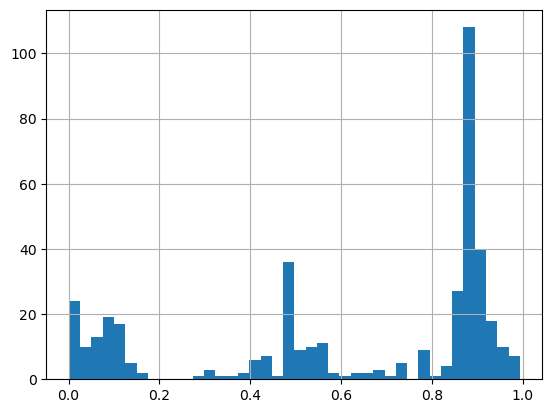

In [50]:
pd.Series(preds[:,0].numpy().squeeze()).hist(bins=40) #with category block

Interestingly, there are 3 peaks in the distribution:

* People who died (on the left)
* People who maybe died/survived (in the middle)
* People who survived (on the right)

By default, you would draw the line at `0.5` to split between died/survived, but what should we do here?

I simply ran the experiment, and here are the submission results:

* Threshold >0.4: Score: 0.75358
* Threshold >0.5: Score: 0.76076
* Threshold >0.6: Score: 0.76315
* Threshold >0.7: Score: **0.77272**
* did not try 0.8 for whatever reason...

Empirically, 0.7 is the best value to making the split

In [57]:
survived = (preds[:,1]>0.7).int()
survived[:5]

tensor([0, 0, 0, 0, 0], dtype=torch.int32)

In [58]:
# create submission file
submission = pd.DataFrame({'PassengerId': tst_df['PassengerId'], 'Survived': survived})
submission.to_csv('submission-fastai4.csv', index=False)

The improvement over the baseline was not amazing, but at least it was better: **0.77272** (compared to 0.76555)

## Ensembling

As suggested in the notebook "[Why you should use a Framework](https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework)", I tried to improve by doing an ensemble, but it did not return a better result...

In [59]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy)
    with learn.no_bar(),learn.no_logging(): learn.fit_one_cycle(10, lr_max=0.1)
    return learn.get_preds(dl=tst_dl)[0]

In [60]:
learns = [ensemble() for _ in range(10)]

In [61]:
ens_preds = torch.stack(learns).mean(0)

<AxesSubplot: >

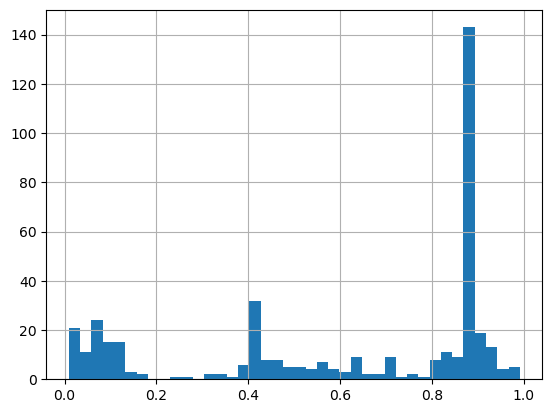

In [62]:
pd.Series(ens_preds[:,0].numpy().squeeze()).hist(bins=40)

In [64]:
survived = (preds[:,1]>0.7).int()
submission = pd.DataFrame({'PassengerId': tst_df['PassengerId'], 'Survived': survived})
submission.to_csv('submission-fastai_ens1.csv', index=False)

The best result for the enseble also was at 0.7 at exactily the same score as the single model: **0.77272**